In [1]:
require 'torch'
require 'nn'
-- cltorch.setDevice(1)

In [2]:
trainset = torch.load('cifar10-train.t7')

In [3]:
testset = torch.load('cifar10-test.t7')
classes = {'airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck'}

In [4]:
setmetatable(trainset, 
    {__index = function(t, i) 
                    return {t.data[i], t.label[i]} 
                end}
);
trainset.data = trainset.data:double() -- convert the data from a ByteTensor to a DoubleTensor.

function trainset:size() 
    return self.data:size(1) 
end

In [5]:
mean = {} -- store the mean, to normalize the test set in the future
stdv  = {} -- store the standard-deviation for the future
for i=1,3 do -- over each image channel
    mean[i] = trainset.data[{ {}, {i}, {}, {}  }]:mean() -- mean estimation
    print('Channel ' .. i .. ', Mean: ' .. mean[i])
    trainset.data[{ {}, {i}, {}, {}  }]:add(-mean[i]) -- mean subtraction
    
    stdv[i] = trainset.data[{ {}, {i}, {}, {}  }]:std() -- std estimation
    print('Channel ' .. i .. ', Standard Deviation: ' .. stdv[i])
    trainset.data[{ {}, {i}, {}, {}  }]:div(stdv[i]) -- std scaling
end

Channel 1, Mean: 125.83175029297	


Channel 1, Standard Deviation: 63.143400842609	


Channel 2, Mean: 123.26066621094	


Channel 2, Standard Deviation: 62.369209019002	


Channel 3, Mean: 114.03068681641	


Channel 3, Standard Deviation: 66.965808411114	


In [6]:
criterion = nn.ClassNLLCriterion()

In [7]:
net = nn.Sequential()
net:add(nn.SpatialConvolution(3, 6, 5, 5)) -- 3 input image channels, 6 output channels, 5x5 convolution kernel
net:add(nn.SpatialMaxPooling(2,2,2,2))     -- A max-pooling operation that looks at 2x2 windows and finds the max.
net:add(nn.SpatialConvolution(6, 16, 5, 5))
net:add(nn.SpatialMaxPooling(2,2,2,2))
net:add(nn.View(16*5*5))                    -- reshapes from a 3D tensor of 16x5x5 into 1D tensor of 16*5*5
net:add(nn.Linear(16*5*5, 120))             -- fully connected layer (matrix multiplication between input and weights)
net:add(nn.Linear(120, 84))
net:add(nn.Linear(84, 10))                   -- 10 is the number of outputs of the network (in this case, 10 digits)
net:add(nn.LogSoftMax())            -- converts the output to a log-probability. Useful for classification problems

In [8]:
shorttrainer = nn.StochasticGradient(net, criterion)
shorttrainer.learningRate = 0.001
shorttrainer.maxIteration = 25 -- just do 5 epochs of training.

In [9]:
shorttrainer:train(trainset)

# StochasticGradient: training	


# current error = 1.9581768871495	


# current error = 1.6718835041189	


# current error = 1.5570486070792	


# current error = 1.4810005267469	


# current error = 1.4189695844086	


# current error = 1.3673584561387	


# current error = 1.3253869931426	


# current error = 1.2891060745735	


# current error = 1.25721470086	


# current error = 1.2285600889006	


# current error = 1.2026231673735	


# current error = 1.1788496420829	


# current error = 1.1569696923519	


# current error = 1.1374519836675	


# current error = 1.1201281333449	


# current error = 1.1038030682727	


# current error = 1.0893413058717	


# current error = 1.0759913251764	


# current error = 1.0635926643515	


# current error = 1.0518116039595	


# current error = 1.0403100031753	


# current error = 1.029902543462	


# current error = 1.0199159615538	


# current error = 1.0105704878253	


# current error = 1.0022457417924	
# StochasticGradient: you have reached the maximum number of iterations	
# training error = 1.0022457417924	



In [10]:
testset.data = testset.data:double()   -- convert from Byte tensor to Double tensor
for i=1,3 do -- over each image channel
    testset.data[{ {}, {i}, {}, {}  }]:add(-mean[i]) -- mean subtraction    
    testset.data[{ {}, {i}, {}, {}  }]:div(stdv[i]) -- std scaling
end

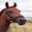

Got: 	bird	
Expected: 	horse	
bird	36.644052760075	
cat	31.887848335677	
dog	21.808258958688	
truck	4.5000602647088	
deer	2.7697160842494	
automobile	1.336727966689	


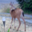

Got: 	deer	
Expected: 	deer	
deer	73.669979511511	
bird	14.874876356776	
horse	6.095836200587	
dog	3.1641595504583	
frog	1.3216059949049	
cat	0.53389929910064	


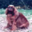

Got: 	dog	
Expected: 	dog	
dog	34.456149170707	
deer	23.917211293964	
horse	17.708219444992	
bird	13.845505162537	
cat	6.7173414377698	
frog	2.5332574069918	


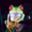

Got: 	frog	
Expected: 	frog	
frog	51.710471646515	
dog	18.018345282864	
horse	17.318783290962	
deer	4.2641485572614	
cat	3.6842830505769	
truck	3.6282539933811	


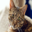

Got: 	cat	
Expected: 	cat	


cat	58.42802163024	
frog	17.986356994855	
horse	14.575560714976	
dog	3.5167076026453	
deer	3.00669027311	
truck	1.4213184613669	


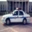

Got: 	automobile	
Expected: 	automobile	
automobile	62.247278915167	
truck	25.127429838682	
airplane	7.9993562489075	
bird	2.0208074012047	
horse	1.050380270542	
ship	0.86647017621528	


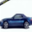

Got: 	ship	
Expected: 	automobile	
ship	62.882367679309	
automobile	36.590601734459	
airplane	0.35317871616617	
truck	0.17090663581894	
bird	9.2229540099913e-05	
cat	2.1745666230034e-05	


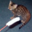

Got: 	bird	
Expected: 	cat	
bird	51.809835298995	
cat	25.085807131459	
frog	8.3493015503957	
airplane	4.3666886942403	
horse	4.327337356253	
dog	4.1572218759324	


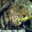

Got: 	frog	
Expected: 	frog	
frog	

67.760614521827	
cat	19.022953004192	
deer	5.3273667569326	
dog	5.3184658722468	
bird	0.99429695756969	
truck	0.84338694218551	


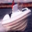

Got: 	frog	
Expected: 	ship	
frog	45.622656555692	
cat	17.446514746999	
horse	16.430184915524	
dog	10.25741789264	
bird	5.6122261784192	
ship	3.1386280711642	


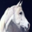

Got: 	dog	
Expected: 	horse	
dog	88.761876317561	
frog	5.0941783917959	
bird	2.2521764420668	
horse	1.8383867787321	
cat	1.4827874472863	
deer	0.55329865672323	


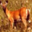

Got: 	dog	
Expected: 	deer	
dog	36.992215481866	
frog	32.766283676788	


horse	17.656178027203	
deer	8.963555633187	
cat	3.1204140255575	
bird	0.43532108727065	


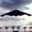

Got: 	airplane	
Expected: 	

airplane	
airplane	68.684640950357	
bird	15.800501020944	
horse	6.9125328450993	
ship	5.3077554978228	
truck	1.773915683289	
automobile	1.4137499100344	


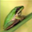

Got: 	bird	
Expected: 	frog	


bird	66.178474787417	
frog	31.552096785472	
deer	1.9021164476318	
cat	0.31587124429511	
dog	0.039472172905512	
horse	0.0067923099635116	


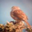

Got: 	bird	
Expected: 	bird	
bird	93.623664510889	
deer	3.0717601995449	
frog	2.2265828777374	
dog	0.40766401343886	
horse	0.2337521739601	
cat	0.18404011895322	


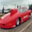

Got: 	automobile	
Expected: 	automobile	
automobile	74.60571655039	
truck	24.192316737452	
horse	1.082585749299	
dog	0.044246844517567	
airplane	0.02745482103285	
deer	0.025758364401452	


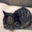

Got: 	horse	
Expected: 	cat	
horse	79.879012383795	
truck	8.8735691586678	
cat	4.0795391081396	
dog	3.4683152516822	
automobile	2.1685596696187	
deer	0.91861574364127	


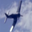

Got: 	airplane	
Expected: 	airplane	
airplane	75.221573102932	
bird	15.370566387246	
dog	5.3619371995067	
ship	2.9497339045023	
cat	0.2924534853115	
horse	0.26472357747214	


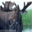

Got: 	cat	
Expected: 	deer	
cat	31.908865477207	
deer	30.894647716002	
horse	28.887355779449	
dog	3.4116759825634	
bird	2.8965944184646	
truck	1.1962383157355	


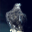

Got: 	dog	
Expected: 	bird	
dog	66.790280871596	
bird	14.254067426064	
cat	14.18640996457	
horse	2.3916695934354	
frog	1.2021455091482	
deer	1.1148639446292	


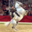

Got: 	frog	
Expected: 	horse	
frog	47.014903472076	
horse	41.939427200534	
cat	6.6987890681404	
dog	1.8847563846394	
automobile	1.469599458516	
deer	0.58389293016801	


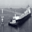

Got: 	ship	
Expected: 	ship	
ship	85.710202022889	
automobile	7.8455854473184	
airplane	5.9367718597297	
truck	0.20868066159901	
frog	0.1617700311207	
bird	0.077051758640736	


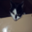

Got: 	dog	
Expected: 	cat	
dog	73.911387638622	
bird	12.060742159815	
cat	11.856092040725	
horse	1.3431474437055	
deer	0.72982715452682	
airplane	0.072325788448413	


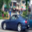

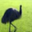

Got: 	deer	
Expected: 	automobile	
deer	51.055762199739	
dog	23.523918519711	
bird	13.636251945551	
automobile	5.5227769157495	
cat	5.2898705524275	
truck	0.30001227761872	


Got: 	bird	
Expected: 	bird	
bird	91.609722625631	
horse	4.5350027780807	
deer	3.0894627579757	
dog	0.68812678529982	
frog	0.045329919931955	
cat	0.023888138623471	


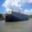

Got: 	airplane	
Expected: 	ship	
airplane	56.57597120058	
ship	36.664345829771	
deer	2.7553366995888	
truck	2.0589535740351	
bird	1.1452586437605	
horse	0.5830568287714	


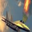

Got: 	bird	
Expected: 	airplane	
bird	76.700247878459	
cat	11.579742123866	
frog	3.4904566225537	
truck	2.850333538172	
deer	1.6266874868059	
airplane	1.4664874591703	


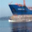

Got: 	ship	
Expected: 	ship	
ship	63.985911127117	
airplane	32.850350688272	
truck	1.958095255577	
bird	0.60213711240576	
automobile	0.28871970456568	
deer	0.20004259241045	


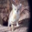

Got: 	cat	
Expected: 	cat	
cat	60.879389365498	
dog	38.529112603654	
deer	0.23556609738497	
frog	0.19209231197646	
truck	0.067161956979884	
automobile	0.057644568831502	


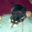

Got: 	cat	
Expected: 	dog	
cat	28.728989887878	
deer	21.568052395982	
frog	21.059381517688	
horse	13.688911266485	
dog	7.4523907293117	
bird	4.1365840626037	


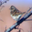

Got: 	frog	
Expected: 	bird	
frog	45.915290604508	
airplane	29.257620047857	
ship	11.962599260829	
cat	6.4173731440204	
bird	4.5928828141209	
deer	0.86189517471744	


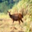

Got: 	deer	
Expected: 	deer	
deer	42.888153507821	
horse	37.638594317079	
frog	10.977546786741	
bird	8.0337517364655	
dog	0.24584087653611	
cat	0.17259326931076	


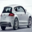

Got: 	automobile	
Expected: 	automobile	
automobile	93.129458042152	
truck	4.6114414276487	
dog	1.8094139323056	
horse	0.28115335481924	
deer	0.087164190323762	
cat	0.039744284698701	


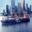

Got: 	truck	
Expected: 	ship	
truck	85.69663963479	
automobile	11.467905208863	
airplane	2.1774220545462	
ship	0.42534326717648	
deer	0.13118365474855	
cat	0.062513192495551	


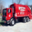

Got: 	truck	
Expected: 	truck	
truck	99.294241542908	
automobile	0.58920127875759	
cat	0.056837977311403	
horse	0.025461341403964	
dog	0.025235821969948	
frog	0.0025394482552185	


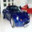

Got: 	horse	
Expected: 	automobile	
horse	37.399604771714	
automobile	20.616754754893	
dog	16.184881752439	
cat	12.266736983698	
truck	10.493303101947	
deer	2.6391148751012	


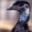

Got: 	cat	
Expected: 	bird	
cat	33.647032725576	
dog	22.483720588726	
frog	16.086181982338	
deer	10.59052846077	
bird	9.2685963974261	
automobile	2.5478780121602	


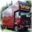

Got: 	truck	
Expected: 	truck	
truck	77.951934163093	
automobile	21.692783768073	
dog	0.20099812769593	
horse	0.067223392901792	
cat	0.05446995437089	
ship	0.027494291840537	


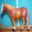

Got: 	horse	
Expected: 	horse	
horse	91.977863528209	
bird	4.3846002113913	
deer	2.3592257261317	
dog	0.79832962773844	
cat	0.33573103921948	
truck	0.094321387367701	


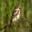

Got: 	bird	
Expected: 	bird	
bird	54.833765058617	
deer	27.953210860052	
dog	10.064483726558	
frog	3.144211918797	
cat	2.890039785616	
horse	1.1078097354695	


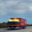

Got: 	ship	
Expected: 	truck	
ship	61.596591500759	
airplane	35.410732527203	
truck	1.4747468555601	
automobile	1.4506654480591	
bird	0.060638634986109	
deer	0.0016488543823932	


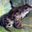

Got: 	frog	
Expected: 	frog	
frog	63.256272657356	
cat	19.333347299812	
dog	6.1213803344867	
bird	3.6765569184773	
automobile	2.7371823130441	
deer	2.103269454214	


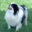

Got: 	dog	
Expected: 	dog	
dog	82.980183406317	
horse	12.942934423094	
bird	4.0142020946518	
cat	0.028349066682877	
truck	0.011093215227046	
ship	0.0085926678192217	


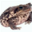

Got: 	frog	
Expected: 	frog	
frog	72.390305426743	
truck	8.8213397589824	
cat	7.1431388018806	
dog	3.460353979571	
bird	2.5589892663554	
automobile	2.5449962942423	


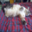

Got: 	cat	
Expected: 	cat	
cat	51.163117092657	
dog	36.619147443825	
horse	5.1844668492793	
deer	3.2716828916153	
truck	2.2663061784335	
bird	0.84968951341444	


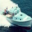

Got: 	airplane	
Expected: 	ship	
airplane	46.152420169517	
ship	43.38026513905	
automobile	10.214187548995	
truck	0.19041109920308	
horse	0.049427041190376	
bird	0.0078943381237899	


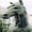

Got: 	horse	
Expected: 	horse	
horse	43.918183512484	
airplane	18.994688742255	
deer	13.078824441796	
frog	9.8224265773963	
cat	6.0174470131734	
bird	3.1785810663685	


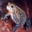

Got: 	frog	
Expected: 	frog	
frog	47.374180176584	
cat	41.35994325948	
dog	4.9601982913985	
horse	3.0873433503723	
deer	2.6368515314495	
bird	0.3362225107759	


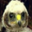

Got: 	frog	
Expected: 	bird	
frog	54.607633608294	
dog	43.652194714693	
cat	1.467825350237	
horse	0.2220116163377	
deer	0.02739024547597	
bird	0.018169518595088	


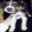

Got: 	dog	
Expected: 	dog	
dog	53.215775871575	
cat	44.099407578032	
deer	1.0464307234487	
automobile	1.005061631092	
horse	0.35586926033506	
frog	0.20777355222547	


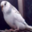

Got: 	cat	
Expected: 	bird	
cat	47.828563036891	
dog	36.271814882836	
bird	10.416828406585	
horse	3.9840413065397	
deer	0.58565902501977	
truck	0.42216195789109	


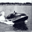

Got: 	automobile	
Expected: 	ship	
automobile	99.410390565648	
ship	0.2581459277443	
truck	0.20169933224474	
airplane	0.11639597143463	
bird	0.004609383362979	
deer	0.00067948611102595	


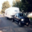

Got: 	automobile	
Expected: 	truck	
automobile	80.664507999099	
truck	7.4255751662482	
ship	4.0767825515764	
dog	2.297808077859	
cat	2.0795934086455	
horse	2.0338232839053	


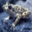

Got: 	cat	
Expected: 	frog	
cat	32.34973798195	
frog	29.52086579745	
deer	13.90876730964	
bird	13.047053756697	
dog	5.4245810894519	
horse	2.9598099504503	


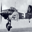

Got: 	horse	
Expected: 	airplane	
horse	26.174902521945	
dog	21.421605100302	
cat	17.339255891753	
airplane	13.938193864795	
truck	9.8203661343481	
bird	9.1403186735405	


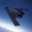

Got: 	bird	
Expected: 	airplane	
bird	39.58322253847	
cat	19.599467335713	
deer	16.615446010751	
dog	13.572922287523	
airplane	8.9928256798468	
frog	0.66952292170325	


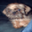

Got: 	frog	
Expected: 	dog	
frog	42.706016019644	
deer	23.567013255729	
cat	14.972658202751	
dog	11.265744967685	
bird	3.1988078768807	
horse	2.4111560791686	


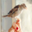

Got: 	bird	
Expected: 	bird	
bird	75.766093648534	
dog	8.2929712487528	
cat	6.2951031263534	
deer	4.9163157161605	
horse	3.2089225314454	
frog	1.2469068740593	


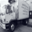

Got: 	truck	
Expected: 	truck	
truck	34.38035889879	
ship	31.888032833523	
airplane	28.288156627044	
automobile	4.7700599493388	
deer	0.29252703996356	
cat	0.16984107205512	


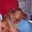

Got: 	cat	
Expected: 	dog	
cat	76.555866478247	
dog	13.899797689194	
frog	4.57815054055	
deer	4.2694734718348	
horse	0.41666551099285	
bird	0.10795327853528	


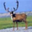

Got: 	airplane	
Expected: 	deer	
airplane	58.309300226271	
ship	11.923535100406	
truck	9.5330959746353	
horse	7.9999665924006	
deer	7.9177737949437	
bird	3.4825409964189	


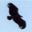

Got: 	airplane	
Expected: 	bird	
airplane	53.28397221155	
cat	34.20886249157	
horse	6.5970519331908	
bird	2.8782360830169	
dog	2.4250339854584	
deer	0.26908015481933	


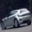

Got: 	automobile	
Expected: 	automobile	
automobile	94.505189110868	
airplane	2.5549250071815	
frog	1.0505700125028	
truck	1.0221416057363	
cat	0.33980169228965	
ship	0.17730666267834	


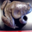

Got: 	frog	
Expected: 	frog	
frog	33.345483312532	
automobile	27.011878495729	
cat	26.452845455721	
dog	6.8210312577962	
horse	2.9307502400918	
bird	2.2381322207708	


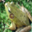

Got: 	frog	
Expected: 	frog	
frog	84.468582661743	
dog	8.2154573816159	
cat	3.4927961112585	
bird	2.9292041891654	
deer	0.76095920194338	
horse	0.12452439972002	


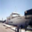

Got: 	ship	
Expected: 	ship	
ship	44.790652893397	
airplane	34.726175270021	
bird	13.659350778791	
automobile	2.2160980479602	
frog	1.2977626330507	
deer	1.0424660962116	


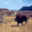

Got: 	airplane	
Expected: 	deer	
airplane	48.763782087681	
horse	27.787261750783	
truck	15.232299204902	
deer	4.9702725936651	
automobile	1.9939570099035	
bird	0.69305523958084	


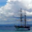

Got: 	ship	
Expected: 	ship	
ship	97.705594426451	
airplane	1.8487777869079	
bird	0.22359259406163	
automobile	0.08307206586529	
truck	0.063202036627143	
deer	0.021695757771038	


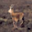

Got: 	deer	
Expected: 	deer	
deer	36.402877323951	
frog	21.2701431512	
horse	17.437006775959	
bird	13.488217480959	
cat	5.4751638256155	
dog	4.474306774688	


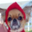

Got: 	horse	
Expected: 	dog	
horse	51.709998846288	
frog	30.623164918713	
dog	9.5299832592674	
cat	6.0606500358164	
truck	2.0308557461455	
bird	0.022590805016779	


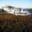

Got: 	ship	
Expected: 	airplane	
ship	60.76703434224	
horse	22.714200893604	
airplane	7.33277534996	
truck	5.4208472775642	
bird	1.3171087274296	
deer	1.0692872894561	


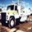

Got: 	truck	
Expected: 	truck	
truck	86.428327902024	
dog	4.4294061763345	
cat	4.2038755794146	
automobile	4.0144240093743	
frog	0.51960354964671	
ship	0.20992615800755	


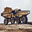

Got: 	truck	
Expected: 	truck	
truck	60.517372289526	
frog	19.015816653266	
horse	12.658951568069	
airplane	6.1712732454082	
cat	0.85028137346472	
automobile	0.63911872963521	


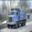

Got: 	truck	
Expected: 	truck	
truck	35.676778799671	
automobile	24.739372311852	


ship	16.96332102492	
bird	7.2478296531011	
deer	5.4826861301179	
cat	3.8778165826758	


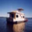

Got: 	airplane	
Expected: 	ship	
airplane	54.543717033251	
ship	44.097257913711	
automobile	0.73113126923155	
bird	0.29488593951585	
truck	0.20079085662883	
horse	0.11663206030908	


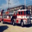

Got: 	truck	
Expected: 	truck	
truck	85.470594654068	
automobile	13.422213054754	
horse	0.56017871300656	
frog	0.22329195696361	
deer	0.19315728377429	
ship	0.081399004703273	


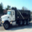

Got: 	truck	
Expected: 	truck	
truck	97.969483061814	
automobile	0.91460703156487	
ship	0.7871869469521	
airplane	0.27655148839761	
cat	0.030615283543325	
bird	0.010281573264675	


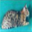

Got: 	ship	
Expected: 	cat	
ship	94.163480975426	
truck	3.0467208960764	
airplane	1.3144918636306	
bird	0.66923346750753	
automobile	0.37783888510879	
frog	0.22901529258938	


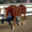

Got: 	horse	
Expected: 	horse	
horse	93.338791225014	
cat	2.7394586945192	
truck	1.7532881144572	
dog	0.6063975557152	
bird	0.55832449360059	
deer	0.48107231704213	


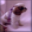

Got: 	dog	
Expected: 	dog	
dog	55.631095677591	
cat	33.98251313	
deer	5.5750522012691	
bird	2.3160642634853	
airplane	1.066732198353	
horse	0.75452724857119	


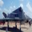

Got: 	automobile	
Expected: 	airplane	
automobile	60.514989220137	
truck	21.659550496736	
ship	12.216480218628	
airplane	5.1745489196831	
horse	0.28363704958475	
deer	0.065500918605964	


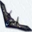

Got: 	ship	
Expected: 	airplane	
ship	81.455878357544	
airplane	9.6956356843997	
truck	4.6530463113712	
frog	2.9110681686729	
cat	0.8500763697823	
automobile	0.35636841002494	


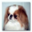

Got: 	dog	
Expected: 	dog	
dog	58.15998592828	
horse	25.067682646872	
cat	16.455315742949	
bird	0.12961484824483	
truck	0.10068773737654	
frog	0.036644424357926	


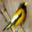

Got: 	frog	
Expected: 	bird	
frog	95.476327120415	
deer	2.1263480375285	
cat	1.2260283507732	
horse	0.63869104825465	
dog	0.40448087643411	
bird	0.11276046012689	


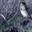

Got: 	cat	
Expected: 	bird	
cat	38.117132172871	
bird	25.171601927924	
dog	16.405141413182	
frog	6.766515396455	
deer	6.3003508354195	
ship	5.4507476618982	


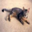

Got: 	horse	
Expected: 	cat	
horse	88.851051653124	
dog	5.5506959647396	
frog	1.9389116323689	
deer	1.7346252918924	
cat	1.2701481297567	
bird	0.51720818649226	


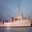

Got: 	ship	
Expected: 	ship	
ship	81.238324109598	
airplane	18.074879085434	
bird	0.31176454021447	
horse	0.1578001030953	
deer	0.10514614317025	
truck	0.083164455258282	


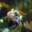

Got: 	cat	
Expected: 	frog	
cat	27.039053168009	
frog	24.718778241881	
deer	21.056738990237	
bird	14.988454814935	
dog	9.6244100824796	
ship	1.7500109401347	


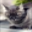

Got: 	cat	
Expected: 	cat	
cat	50.222458141933	
bird	14.749340390646	
dog	14.312869378043	
frog	5.7479317870214	
airplane	3.5604425314282	
horse	3.4403025784751	


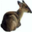

Got: 	horse	
Expected: 	deer	
horse	87.212879510095	
cat	7.2301926354292	
dog	2.5864046611156	
truck	1.3924048558444	
bird	1.2847247115099	
airplane	0.15454604443785	


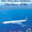

Got: 	ship	
Expected: 	airplane	
ship	99.728945268239	
airplane	0.25145683810946	
automobile	0.010794757632051	
truck	0.0057215976398757	
bird	9.9914514658227e-06	
horse	1.0340262094429e-08	


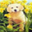

Got: 	frog	
Expected: 	dog	
frog	30.33933319892	
dog	29.565159710529	
horse	17.226486396913	
deer	15.322411476396	
bird	6.0992662220804	
cat	1.326814943241	


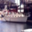

Got: 	automobile	
Expected: 	ship	
automobile	64.381556688041	
truck	20.669239315888	
cat	6.9412196255654	
airplane	4.081542135613	
ship	1.507759264906	
dog	1.4144264230569	


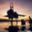

Got: 	ship	
Expected: 	airplane	
ship	68.757800879075	
truck	11.606573622549	
airplane	9.6902280926036	
automobile	9.61192806765	


horse	0.2188785453921	
deer	0.060804450541208	


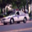

Got: 	automobile	
Expected: 	automobile	
automobile	92.050046194438	
frog	3.1186079563677	
airplane	2.4010513153689	
horse	0.87707797914869	
truck	0.32088761488696	
bird	0.3167854395907	


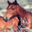

Got: 	horse	
Expected: 	horse	
horse	71.194727018641	
cat	6.9138616037022	
deer	6.429453661598	
bird	6.2375173312256	
dog	4.9450515317147	
frog	2.0663674698856	


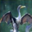

Got: 	cat	
Expected: 	bird	
cat	34.182950623556	
dog	26.756846977514	
deer	15.368365488506	
frog	14.474055111322	
bird	4.6837530820917	
horse	2.5489912204439	


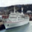

Got: 	truck	
Expected: 	ship	
truck	46.196879382903	
ship	43.579133750151	
cat	5.9099330391961	
automobile	3.128362875719	
dog	0.69418365738342	
frog	0.35615929197094	


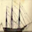

Got: 	ship	
Expected: 	ship	
ship	94.134855134039	
deer	1.5340678885081	
truck	1.2825693298862	
bird	1.2817242889313	
airplane	0.91725590816911	
cat	0.39201665036633	


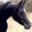

Got: 	horse	
Expected: 	horse	
horse	81.920026524126	
dog	12.501524233049	
cat	2.9598792327449	
bird	1.6145894282694	
frog	0.78180209595284	
deer	0.19475760748526	


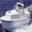

Got: 	cat	
Expected: 	ship	
cat	24.07574713188	
ship	22.417161222937	
automobile	13.132078163006	
deer	11.979646519019	
airplane	10.180704620109	
dog	7.7931499429033	


In [11]:
for j=100,200 do
    local theimage = testset.data[j]
    
    itorch.image(theimage)
    local groundtruth = testset.label[j]
    local prediction = net:forward(testset.data[j])
    local pred = prediction:exp()

    local confidences, indices = torch.sort(prediction, true)  -- true means sort in descending order
    print("Got: ", classes[indices[1]])
    print("Expected: ", classes[groundtruth])
--    if groundtruth == indices[1] then
--        correct = correct + 1
--    end
    for i=1,6 do
        print(classes[indices[i]], confidences[i] * 100)
    end
end